In [1]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import random
import math

In [2]:
VARIABLES = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']
SAMPLING_RATE = 1/60
IMAGE_HEIGHT = 370 # height size of standard spectrogram (matplotlib)

In [18]:
# User change:
SEGMENT_LENGTH = 100 # width of one segment [pixels] (full day data is 370x497 pixels)
OVERLAP = 0.5 # of neighbouring segments [%]
FILTER_THRESHOLD = 0.8 # discard segment if contains >FILTER_THRESHOLD aritificial data [%]

In [4]:
def get_time_series(dat, variable, day):
    entry = dat[variable][day]
    time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
        if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string
    return time_series

def plotter(day, dat):
    """
    Plots time-series of physiological variables for specific day
    """
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(get_time_series(dat, 'HR', day))

    for i, variable in enumerate(VARIABLES):
        time_series = get_time_series(dat, variable, day)

        assert len(time_series) == length, 'time-series data lengths differ!'

        col = 'green' if dat['VAS'][day] == 0.0 else 'red'
        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series, col)
        plt.xlim([0, length])

def plotter_spec(day, dat, NFFT=256, noverlap=128):
    """
    Plots spectrograms of physiological variables for specific day
    """
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(get_time_series(dat, 'HR', day))

    for i, variable in enumerate(VARIABLES):
        time_series = get_time_series(dat, variable, day)

        assert len(time_series) == length, 'time-series data lengths differ!'

        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.specgram(time_series, Fs=SAMPLING_RATE, NFFT=256, noverlap=128)

def na_visualizer(days, dat):
    """
    Plots missing data for specific days in red/green
    """
    for day in days:
        length = get_time_series(dat, 'ActivityCounts', day).shape[0]
        n_variables = len(VARIABLES)
        na_matrix = np.zeros((n_variables, length))

        for i, variable in enumerate(VARIABLES):
            time_series = get_time_series(dat, variable, day)

            na_data = np.where(np.isnan(time_series), 0.0, 1.0) # NaN -> 0, data -> 1
            na_matrix[i, :] = na_data

        # hack: below makes sure colors in image are matched correctly (if all missing/no missing would break otherwise)
        na_matrix[1, 1] = 0.0
        na_matrix[2, 1] = 1.0

        # plot
        cmap = matplotlib.colors.ListedColormap(['red', 'green'])
        plt.figure()
        plt.imshow(na_matrix, cmap=cmap, aspect='20', interpolation='nearest')
        plt.title(f'day {day}')
        plt.xlabel('data length [min]')
        plt.ylabel('variable')

def na_sequence_lengths(dat):
    """
    Calculates lengths of missing data sequences of full dataset
    """
    # check NA sequence lengths
    n_days, n_cols = dat.shape

    total_missing_values = 0
    na_sequences_data = []
    for day in range(n_days):
        for variable in VARIABLES:
            time_series = get_time_series(dat, variable, day)

            na_sequences = []
            na_seq = 0
            for datapoint in time_series:
                if not np.isnan(datapoint):
                    if na_seq > 0:
                        na_sequences.append(na_seq)
                        total_missing_values += na_seq
                        na_seq = 0
                else:
                    # datapoint is NA
                    na_seq += 1
            na_sequences_data += na_sequences

    # show numerical distribution of NA sequence lengths
    temp = pd.DataFrame(np.array(na_sequences_data), columns=['n'])
    query = '''
    SELECT n AS sequence_length, COUNT(*) AS occurrences
    FROM temp
    GROUP BY n;'''
    temp = sqldf(query)

    # plot distribution of NA sequence lengths
    temp.plot.bar(x='sequence_length', y='occurrences', width=2, title=f'Missing data (total: {total_missing_values})')
    plt.xticks([])
    plt.xlim([-10, temp.shape[0]])

    return temp

def imputer(dat, max_fill=50, method='linear'):
    """
    Imputes missing data for full dataset
    """
    dat2 = dat.copy()

    for variable in VARIABLES:
        time_series_all_days = []
        for day in range(dat2.shape[0]):
            time_series = get_time_series(dat, variable, day)
            time_series_all_days.append(time_series)

        pre_imputation = pd.DataFrame(time_series_all_days)
        post_imputation = pre_imputation.interpolate(method=method, axis=1, limit=max_fill, limit_direction='both')

        # update dataframe with imputation data
        for day in range(dat2.shape[0]):
            dat2[variable].iloc[day] = np.array(post_imputation.iloc[day])

    return dat2

def missing_data_per_variable(dat):
    """
    Calculates missing data ratio for each variable
    """
    dat2 = dat.copy()

    missing_data_variable = {variable: [] for variable in VARIABLES}
    for variable in VARIABLES:
        for day in range(dat2.shape[0]):
            time_series = get_time_series(dat, variable, day)
            na_data = list(np.where(np.isnan(time_series), 0.0, 1.0)) # NaN -> 0, data -> 1
            missing_data_variable[variable] += na_data

    missing_data_variable = {variable: np.mean(na_data) for variable, na_data in missing_data_variable.items()}
    return missing_data_variable

def spectrogram_as_array(time_series, NFFT=256, noverlap=128, iteration=1):
    """
    Retrieves numerical data from spectrogram
    """
    # calculate spectrogram
    fig = plt.figure()
    fig.add_subplot(111)
    plt.specgram(time_series,
                 Fs=SAMPLING_RATE,
                 NFFT=NFFT,
                 noverlap=noverlap)
    plt.axis('off') # removes everything except content of plot

    # need to draw plot to create spectrogram
    fig.canvas.draw()

    # save pixels in numpy array
    numerical = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    numerical = numerical.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close() # prevent showing plot

    # remove white padding around spectrogram image
    height, width, channels = numerical.shape
    all_white_rows = np.where(np.sum(numerical[:, :, 0], axis=1) == 255 * width)[0]
    all_white_cols = np.where(np.sum(numerical[:, :, 0], axis=0) == 255 * height)[0]

    start_row, end_row = max(all_white_rows[all_white_rows - np.mean(all_white_rows) < 0]), \
                         min(all_white_rows[all_white_rows - np.mean(all_white_rows) > 0])
    start_col, end_col = max(all_white_cols[all_white_cols - np.mean(all_white_cols) < 0]), \
                         min(all_white_cols[all_white_cols - np.mean(all_white_cols) > 0])

    numerical = numerical[start_row:end_row, start_col:end_col, :]

    # check if spectrogram not enough data (e.g. spectrogram collapse)
    height, width, channels = numerical.shape
    if height < IMAGE_HEIGHT:
        # choice of 3 is arbitrary
        assert iteration < 3, \
            f'not possible to create spectrogram with time-series of ' \
            f'length {len(time_series)} (min: {min(time_series)}, max: {time_series})'

        print(f'Image height mismatch: {height} instead of {IMAGE_HEIGHT} -> adding gaussian noise x{iteration}')
        length = len(time_series)
        noise = np.random.normal(0, 1e-3, length)
        time_series += noise
        return spectrogram_as_array(time_series, iteration=iteration+1)

    return numerical

def save_spectrogram(spectrogram, name):
    """
    Saves spectrogram as png
    """
    plt.figure()
    plt.imshow(spectrogram)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'./Output/{name}.png')
    plt.close() # prevent showing plot

def segmentor(image):
    """
    Segments images into subimages (along width axis)
    """
    height, width, channels = image.shape
    segments = []
    delta = int(OVERLAP * SEGMENT_LENGTH) # distance between two windows

    start, end = 0, SEGMENT_LENGTH
    while True:
        # check if building one more segment is possible
        if end > width - 1: # last pixel column is image[:, width - 1, :]
            break
        else:
            # possible to build segment
            segment = image[:, start:end, :]
            segments.append(segment)

        # move window further
        start += delta
        end += delta

    return segments

def plot_segments(image):
    """
    Plots image with visible segmentations
    """
    segments = segmentor(image)

    plt.figure()
    n = len(segments)
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(segments[i])
        plt.xticks([]), plt.yticks([])

# Import data

In [5]:
# file path to data folder
path = './Output'

In [6]:
file = path + f'/combined_data.csv'
data = pd.read_csv(file, index_col=0).fillna(pd.NA)

# Filter 1/2

Filter out variables from dataset

Text(0, 0.5, 'available data [%]')

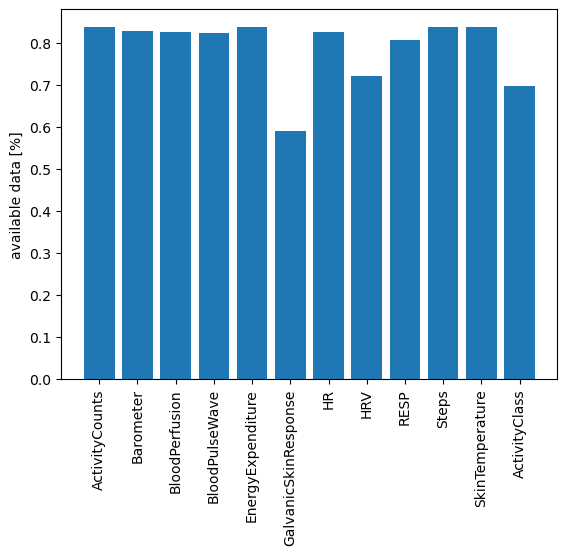

In [7]:
# missing data per variable
temp = missing_data_per_variable(data)

plt.bar(x=temp.keys(), height=temp.values())
plt.xticks(rotation=90)
plt.ylabel('available data [%]')

In [8]:
# discard variables from dataset (too much missing data)
to_discard = ['GalvanicSkinResponse', 'ActivityClass']

data = data.drop(columns=to_discard)
VARIABLES = [variable for variable in VARIABLES if variable not in to_discard]

Filter out days with few data

In [9]:
discarded_days = []

days = range(data.shape[0])
for day in days:
    time_series = get_time_series(data, VARIABLES[0], day)
    length = len(time_series)

    # if cannot build at least one segment -> discard day
    if length < SEGMENT_LENGTH:
        discarded_days.append(day)

data = data.drop(discarded_days)
data = data.reset_index()
print(f'Discarded days (few data): {discarded_days}')

Discarded days (few data): [312, 357]


Filter out days with sensors out all days

In [10]:
discarded_days = []

days = range(data.shape[0])
for day in days:
    for variable in VARIABLES:
        time_series = get_time_series(data, variable, day)
        length = len(time_series)

        # if only missing data for full day -> discard day
        if np.sum(np.where(np.isnan(time_series), 0.0, 1.0)) == 0: # NaN -> 0, data -> 1
            discarded_days.append(day)

data = data.drop(discarded_days)
data = data.reset_index()
print(f'Discarded days (sensor out): {discarded_days}')

Discarded days (sensor out): [114]


# Imputation

In [11]:
# imputation (everything)
MAX_FILL = 1440 # maximum imputation window (from both sides!)
METHOD = 'linear' # imputation method

data_imputed = imputer(data, max_fill=MAX_FILL, method=METHOD)

/var/folders/tq/31s58g8x49x32phm81cky_s40000gn/T/ipykernel_87556/2777639408.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat2[variable].iloc[day] = np.array(post_imputation.iloc[day])


# Spectrogram conversion

### TODO: black bar in spectrogram

In [12]:
# compute spectrogram for all days + variables
days, _ = data_imputed.shape
data_spectrogram = {day: {variable: spectrogram_as_array(get_time_series(data_imputed, variable, day))
                          for variable in VARIABLES}
                    for day in range(days)}

/Users/janoschjungo/opt/anaconda3/envs/ai/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7622: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Image height mismatch: 1 instead of 370 -> adding gaussian noise x1
Image height mismatch: 1 instead of 370 -> adding gaussian noise x1
Image height mismatch: 1 instead of 370 -> adding gaussian noise x1
Image height mismatch: 1 instead of 370 -> adding gaussian noise x1
Image height mismatch: 1 instead of 370 -> adding gaussian noise x1
Image height mismatch: 1 instead of 370 -> adding gaussian noise x1
Image height mismatch: 1 instead of 370 -> adding gaussian noise x1
Image height mismatch: 1 instead of 370 -> adding gaussian noise x1
Image height mismatch: 1 instead of 370 -> adding gaussian noise x1
Image height mismatch: 1 instead of 370 -> adding gaussian noise x1
Image height mismatch: 1 instead of 370 -> adding gaussian noise x1
Image height mismatch: 1 instead of 370 -> adding gaussian noise x1
Image height mismatch: 1 instead of 370 -> adding gaussian noise x1
Image height mismatch: 1 instead of 370 -> adding gaussian noise x1
Image height mismatch: 1 instead of 370 -> addin

In [17]:
# check if all spectrograms correct sizes
for variable in VARIABLES:
    for day in data_spectrogram.keys():
        assert data_spectrogram[day][variable].shape[0] == IMAGE_HEIGHT, f'different height: {day}, {variable}'
print('All spectrograms correct size!')

All spectrograms correct size!


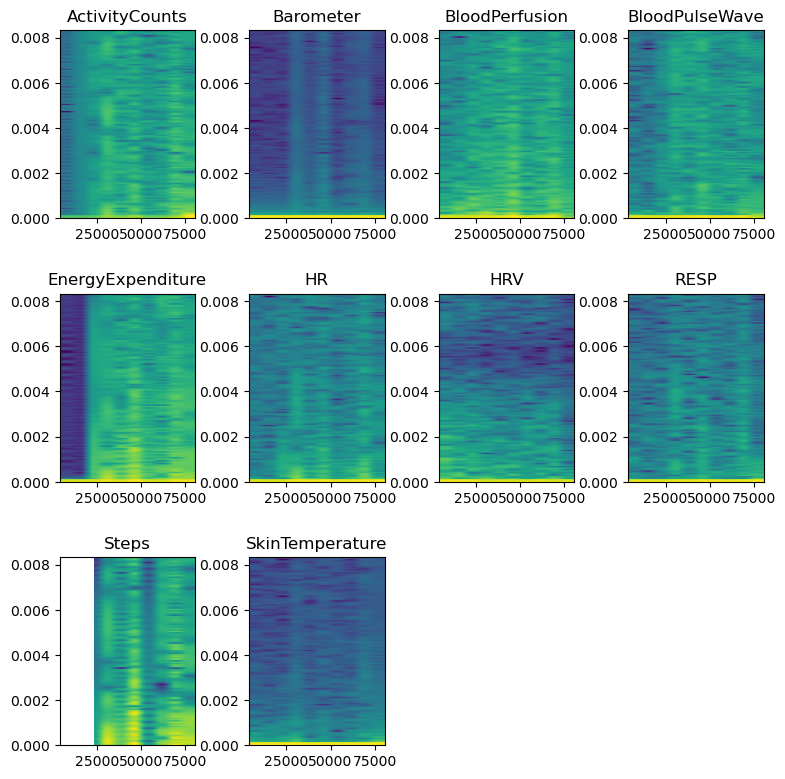

In [14]:
plotter_spec(367, data_imputed) # black bars (go away after filtering out missing data seq.?)

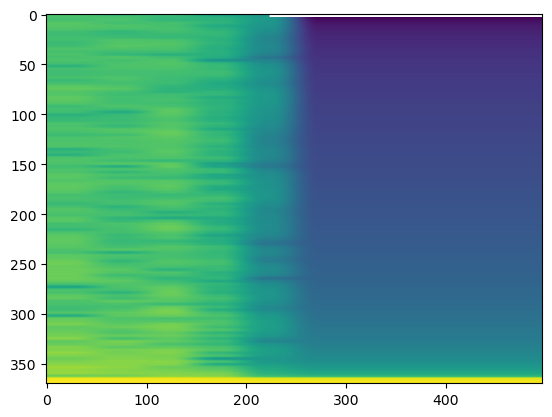

In [15]:
plt.imshow(data_spectrogram[0]['HR']) # black bar in first row?

# Segmentation

96 ActivityCounts


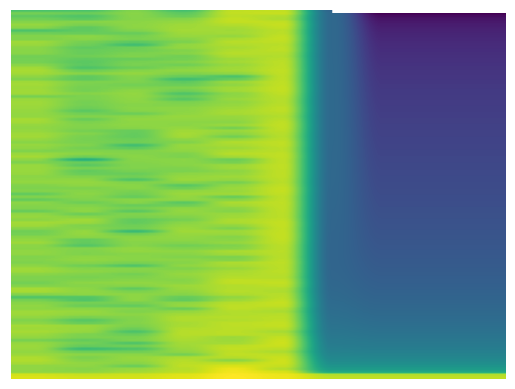

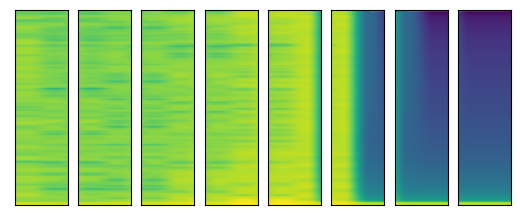

In [16]:
# visualization
day = random.sample(range(data.shape[0]), 1)[0]
variable = random.sample(VARIABLES, 1)[0]

image = data_spectrogram[day][variable]

plt.imshow(image)
plt.axis('off')
plot_segments(image)

print(day, variable)

# Filter 2/2

Discard segments with too much artificial data

# Data augmentation